# Income

In [1]:
#the rule of today game is the following:
#if 8 person submit the answer in the chat, then we continue...
#so if you guys are faster, than we can finish this early...
#chaky will not CODE a single line....he will only copy you guys code....

In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

In [3]:
df = pd.read_csv('../data/income.csv')
#get this file from the google classroom

In [4]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [5]:
#please check the class label - test task
df['label'].value_counts(normalize=True)
#again, deep learning should be able to handle this for us
#but you can always use imblearn library

0    0.723333
1    0.276667
Name: label, dtype: float64

## 2. Categorify

Please categorify all categorical columns

sex, education-num, marital-status, workclass, occupation

In [6]:
cat_cols  = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week'] 
y         = ['label']

In [7]:
#change all cat_cols in type category
#why need to categorify?
#underhood:  things become integers, but you don't lose the string

for col in cat_cols:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30000 non-null  int64   
 1   sex             30000 non-null  category
 2   education       30000 non-null  object  
 3   education-num   30000 non-null  category
 4   marital-status  30000 non-null  category
 5   workclass       30000 non-null  category
 6   occupation      30000 non-null  category
 7   hours-per-week  30000 non-null  int64   
 8   income          30000 non-null  object  
 9   label           30000 non-null  int64   
dtypes: category(5), int64(3), object(2)
memory usage: 1.3+ MB


## 3. Create embedding sizes

In [8]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]
emb_size = [(size,min(50,size//2)) for size in cat_size]
emb_size

[(2, 1), (14, 7), (6, 3), (5, 2), (12, 6)]

In [9]:
#so can you guys explain to yourself, e.g., what is (12, 6) mean?
# df['occupation'].unique()
#each of the occupation is represent by a unique vector of size 6....

## 4. Combine all categorical column into one tensor

In [10]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int32)
cats.shape

torch.Size([30000, 5])

## 5. Combine all continuous column into one tensor

In [11]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float32)
conts.shape

torch.Size([30000, 2])

## 6. Turn your y into tensor

In [12]:
#you should be able to answer what is shape of y that pyTorch likes
#(sample) or (sample, 1) or (sample, target)  -->  (sample)
y = torch.tensor(df[y].values).flatten()  #reshape(-1)
y.shape

torch.Size([30000])

## 7. Create your training and testing set for cat and cont and y

In [13]:
train_size = 6000
test_size  = 1000
#why Chaky don't use PyTorch datasets or dataloader?
#silly question, why Chaky don't use all the dataset (30,000)
#actually, Chaky should have use validation set
cat_train = cats[:train_size]
cat_test  = cats[train_size:test_size+train_size]
con_train = conts[:train_size]
con_test  = conts[train_size:test_size+train_size]
y_train   = y[:train_size]
y_test    = y[train_size:test_size+train_size]

## 8. Create the model

In [14]:
#use the exact model as yesterday
class IncomeModel(nn.Module):
    def __init__(self, emb_size, cont_size, out_size, layer_size = [200,100], p = 0.5):
        super().__init__()
        self.embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])
        self.dropout = nn.Dropout(p)
        self.batchnorm1d = nn.BatchNorm1d(cont_size)

        cat_size = sum(emb_s for _, emb_s in emb_size)
        input_size = cat_size + cont_size
        layerlist = []
        for i in layer_size:
            layerlist.append(nn.Linear(input_size,i)) #(input_size,200)
            layerlist.append(nn.ReLU(inplace=True)) 
            layerlist.append(nn.BatchNorm1d(i)) 
            layerlist.append(nn.Dropout(p))
            input_size = i 
        layerlist.append(nn.Linear(layer_size[-1],out_size))

        self.layers = nn.Sequential(*layerlist) #* is same as nn.ModuleList
            
    def forward(self, x_cat,x_cont):
        #x_cat.shape:  (sample_size, 5)
        #x_cont.shape: (sample_size, 2)
        embeddings = []
        for i,e in enumerate(self.embed_layer):
            embeddings.append(e(x_cat[:,i]))
        #embeddings.shape: [(sample_size, emb_size1), 
        #                   (sample_size, emb_size2), 
        #                   (sample_size, emb_size3), 
        #                   (sample_size, emb_size4), 
        #                   (sample_size, emb_size5)  ]  
        x = torch.cat(embeddings,1) 
        #embeddings.shape: ????
        x = self.dropout(x)  #what will happen after dropout? -->
        x_cont = self.batchnorm1d(x_cont) #what will happen after batchnorm1d? --->
        x = torch.cat([x,x_cont],1) #x: (?????, ???)
        x = self.layers(x)
        #last x.shape:  ????
        return x
        
#I don't know....this is called designing neural network
#you know what is dropout, batchnorm, but combining them is like an ART.....trial and error

In [15]:
sample_cat = cats[:1]
sample_cat.shape  #one sample of five categorical features
#['sex', 'education-num', 'marital-status', 'workclass', 'occupation']

torch.Size([1, 5])

In [16]:
sample_cont = conts[:1]
sample_cont.shape  #one sample of 2 continous features
#['age', 'hours-per-week']

torch.Size([1, 2])

In [17]:
#then you will understand why         
#x_cat.shape:  (sample_size, 5)
#x_cont.shape: (sample_size, 2)

In [18]:
embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])
embed_layer  
#what is these five things....what are they
#we got five layers
#first layer, converts 2 uniques values into vector of size 1
test_layer = embed_layer[1]
test_layer
#what is (14, 7) means?  
#it means it turn 14 unique values, each with a vector of size 7

Embedding(14, 7)

In [19]:
number = torch.arange(14)
number

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [20]:
output = test_layer(number)
output
#why we need to create a vector representing each category
#--> you can imagine this vector is a numerical representation of each category
#why 7?
#--> I don't know, but I know 7 is good enough to unique represent category 0 to 13
#--> i know good embedding size is half of the unique values....
embed_layer
#why we need five layers, can I use only 1 layer?
#because I have five categorical columns, each with different amount of unique values


ModuleList(
  (0): Embedding(2, 1)
  (1): Embedding(14, 7)
  (2): Embedding(6, 3)
  (3): Embedding(5, 2)
  (4): Embedding(12, 6)
)

In [21]:
embeddings = []
for i,e in enumerate(embed_layer):
    embeddings.append(e(sample_cat[:,i]))
    
embeddings
#embeddings is a randomized values from a uniform distribution (close to 0)


[tensor([[0.5044]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.4602,  1.6739,  0.1997,  0.9124, -0.6707,  0.3829, -0.5612]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[-1.0691, -0.1660,  1.5046]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.9137, 0.0708]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2984,  1.7227,  0.6665,  1.3135,  0.2768, -1.4090]],
        grad_fn=<EmbeddingBackward0>)]

In [22]:
sample_cat

tensor([[1, 6, 3, 2, 1]], dtype=torch.int32)

In [23]:
#((sample_size, 1), (sample_size, 7), (sample_size, 3), (sample_size, 2), (sample_size, 6))

In [24]:
#x1w1 + x2w2 + x3w3 = 10
#maybe x = [1, 2, 3]
#initially, w is randomized = [0.1, -0.9, 0.8]
#but after we backpropagate many times, what is w?
#optimized w = [5, 1, 1]

#1 * 5 + 2 * 1 + 3 * 1 = 10


In [25]:
#category = male, female
#vector of what size =  5

#the feeling of embedding is LIKE THIS

#feature1 = length of the hair,   feature2 = weight, feature3 = height, feature4 = kindness, feature5 = violence
#  male   =    0.2                    0.5                 0.2                  0.1                  0.8
#  female =    0.9                    0.1                 0.2                  0.9                  0.6

# why we cannot come up with our own encoding
# because neural network can come up with better one, through backpropagation...

## 9. Test your model

In [26]:
torch.manual_seed(99999999)  
#in deep learning, usually we cannot do cross-validation
#because it's huge dataset...
#to get multiple performance metrics, we use different seeds
#maybe compare across 5 seeds

#create model
model = IncomeModel(emb_size, conts.shape[1], len(y.unique()))

#try take some sample cat and cont
# cat[:1]
# conts[:1]

#run the model
output = model(cats[:5],conts[:5])

#check the output 
print(output.shape)
#2 is number of targets in our label
#5 is sample size

#is the output shape the thing you wan???
print(output)
#what does this output means
#[ 0.6704,  0.6410] is this????
#[ not-normalized prob of class 0,  not normalized prob of class 1]
# class 0
# why they do not sum to 1

# my next question, when does my output got normalized?


torch.Size([5, 2])
tensor([[ 0.6704,  0.6410],
        [-0.3005,  0.2422],
        [ 0.0334, -0.9228],
        [ 0.9733,  0.1090],
        [ 0.4331,  1.6549]], grad_fn=<AddmmBackward0>)


In [27]:
softmax = nn.Softmax()

soft_out = softmax(output)
soft_out

#hey chaky, but in the last lecture, you NEVER do softmax....never...
#so when does softmax happens????

<ipython-input-27-4df6fd0e737c>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_out = softmax(output)


tensor([[0.5074, 0.4926],
        [0.3676, 0.6324],
        [0.7224, 0.2776],
        [0.7036, 0.2964],
        [0.2276, 0.7724]], grad_fn=<SoftmaxBackward0>)

In [28]:
#when you say loss = CrossEntropyLoss(yhat, y_test)
#CrossEntropyLoss do softmax(yhat) then do cross_entropy with y_test

## 10. Training!!!!

In [36]:
import sklearn.metrics

J_fn      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
            #how can we know lr = 0.01 is good enough
            #why not 0.001, 0.0001
            #because our gradients are very small
            #it make sense that our lr should NOT be too small!
epochs    = 500

losses = []
accs   = []

for i in range(epochs):
    yhat = model(cat_train, con_train)
    loss = J_fn(yhat, y_train)
    
    acc  = sklearn.metrics.accuracy_score(torch.max(yhat, 1)[1], y_train)
    losses.append(loss)
    accs.append(acc)
    
    #you should NOT print the grad after zero_grad
    optimizer.zero_grad()
    #you shoudl print the grad after backward
    loss.backward()
    
    # print(model.layers[0].bias.grad)
    # print(model.layers[4].weight.grad)
    # print(model.layers[4].bias.grad)  
    
    optimizer.step()
    
    if i % 50 == 1:
        print(torch.mean(model.layers[0].weight.grad))
        print(f"Epoch: {i}; Loss: {loss:.2f};acc = {acc:.2f}") 
        print(f'{epochs}: Loss = {losses[-1]};acc = {acc}')
    

tensor(2.0493e-06)
Epoch: 1; Loss: 0.25;acc = 0.89
500: Loss = 0.2466648519039154;acc = 0.887
tensor(-1.0747e-05)
Epoch: 51; Loss: 0.25;acc = 0.89
500: Loss = 0.2479594349861145;acc = 0.8858333333333334
tensor(-1.5936e-06)
Epoch: 101; Loss: 0.25;acc = 0.89
500: Loss = 0.24557310342788696;acc = 0.887
tensor(-3.6470e-06)
Epoch: 151; Loss: 0.25;acc = 0.89
500: Loss = 0.2455696165561676;acc = 0.8883333333333333
tensor(6.5756e-07)
Epoch: 201; Loss: 0.24;acc = 0.89
500: Loss = 0.24458155035972595;acc = 0.885
tensor(-6.7560e-06)
Epoch: 251; Loss: 0.24;acc = 0.89
500: Loss = 0.239524245262146;acc = 0.886
tensor(-5.1672e-06)
Epoch: 301; Loss: 0.24;acc = 0.89
500: Loss = 0.2395138144493103;acc = 0.8871666666666667
tensor(8.0993e-07)
Epoch: 351; Loss: 0.24;acc = 0.89
500: Loss = 0.23547515273094177;acc = 0.8923333333333333
tensor(-2.9191e-06)
Epoch: 401; Loss: 0.23;acc = 0.89
500: Loss = 0.23362407088279724;acc = 0.8923333333333333
tensor(-1.7199e-05)
Epoch: 451; Loss: 0.24;acc = 0.89
500: Loss =

Text(0, 0.5, 'loss')

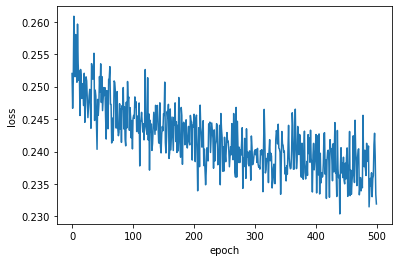

In [37]:
#plot the losses and acc
import matplotlib.pyplot as plt

train_loss = [loss.item() for loss in losses]
plt.plot(range(epochs),train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#maybe 100 epochs are good enough....

Text(0, 0.5, 'acc')

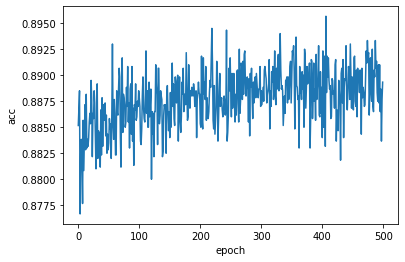

In [38]:
train_acc = [acc.item() for acc in accs]
plt.plot(range(epochs),train_acc)
plt.xlabel('epoch')
plt.ylabel('acc')
#maybe 100 epochs are enough!!!

## 11. Testing!!!

In [39]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    yhat = model(cat_test, con_test)
    loss = J_fn(yhat, y_test)
    predicted = torch.max(yhat, 1)[1]
    acc  = accuracy_score(predicted, y_test)
    
print(acc)

0.884
